# Multilabeling Task for Fashion

##Wenyi Li and Serena Ren
##5.18.2019

# Introduction

Clothing in various cultures reflects many things such as
age, social status, lifestyle and gender. Apparel is also an
important descriptor in identifying different persons. However, understanding fashion is still a very complicated task for computer vision. The field has applications in
social media and e-commerce. We focus on several tasks within the fashion classification umbrella: 

1.   Multilabel classification of clothing attributes
2.   Object detection

Depending on the specific application of fashion classification, the most relevant problems to solve will be different. We will focus on optimizing fashion classification for the
purposes of annotating images and discovering the temporal fashion patterns.

Our pipeline is as follows: given a query image from streetsytle database, 

1.   Detect the person and crop images, record the bounding boxes coordinates,
2.   Predict the clothing attributes. 

The dataset we are using is streetsytle27k (http://streetstyle.cs.cornell.edu/). More detailed exploration and preprocess work can be find in the *preprocess_data.ipython* notebook.

We report accuracy measurements range from 67% to 86% for different attributes.




# Basic setting

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from tqdm import tqdm
import pandas as pd

import sys

sys.path.append('/content/gdrive/My Drive/colab')
from plotting_fns import *

np.random.seed(1)

In [0]:
path = Path('/content/gdrive/My Drive/colab/data/db/')

labels = pd.read_csv(path/'labels.csv')

device = torch.device('cuda')

categories = ['clothing_pattern', 'major_color', 'sleeve_length', 'neckline_shape', 'clothing_category', 'multiple_layers']
labels.loc[labels['label'].isna(), 'label'] = ''

assert not (any(labels['url'].isna()) or any(labels['label'].isna()) or any(labels['test'].isna()) )

In [0]:
#!ls -l 'data/cropped'

total 2680
drwxr-xr-x 2 root root  143360 May 20 16:59 test
drwxr-xr-x 2 root root 2600960 May 20 16:33 train


We have a total of 40 attributes such as color, sleeve length, neckline, etc which have been labeled in our dataset.

In [3]:
crop_imgs = True
bs = 64
if crop_imgs:
    path = 'data/cropped'
else:
    path = 'data/all'
data = (ImageList.from_df(labels[~labels['test']], path, folder='train')
        .split_from_df(col='valid') 
        .label_from_df(label_delim=';')  
        .transform(get_transforms(), size=299)  
        .databunch(bs=bs, device=device).normalize(imagenet_stats))

print(f'Number of classes: {data.c}, training examples: {len(data.train_ds)}')

Number of classes: 40, training examples: 21687


We ramdomly pick several cropped images to plot:

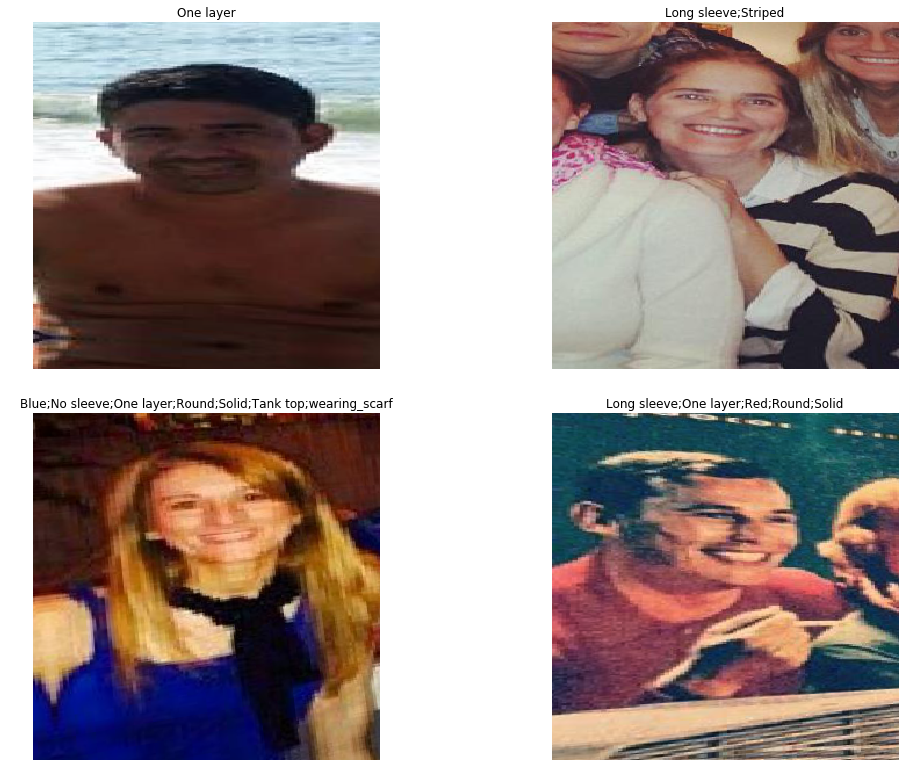

In [0]:
data.show_batch(rows=2, figsize=(15,11))

Reweights

In [0]:
def get_cats(df, col):
    '''
    Returns unique (non-NA) values for column `col` in dataframe `df`
    '''
    na_flag = df[col].isna()
    return df.loc[~na_flag, col].unique()
    
def get_cat_idxs(cats, data_classes):
    '''
    Returns indices `data_classes` that appear in `cats`.
    '''    
    cats, data_classes = np.array(cats), np.array(data_classes)
    assert len(cats.shape) == 1 and len(data_classes.shape) == 1
    return np.where((data_classes[None, :] == cats[:, None]))[1]

def get_y_totals(data):
    '''Counts the label occurence for training data in databunch `data`. (Sums up y values)'''    
    with torch.no_grad():
        sums = [yb.sum(dim=0) for _, yb in tqdm(data.train_dl, position=0)]
        return torch.stack(sums).sum(dim=0)

In [5]:
y_totals = get_y_totals(data)
y_totals

100%|██████████| 338/338 [03:45<00:00,  1.50it/s]


tensor([ 5455.,  1980.,   336.,    29.,  2127.,   751.,  6751.,  3191.,  1115.,
          453., 11220.,  2067.,  7412.,  2903., 13275.,   137.,  3824.,   542.,
          451.,   146.,   954.,  8216.,  3865.,  6003., 13333.,   201.,   914.,
          975.,   725.,  3854.,  1114.,  1725.,  3710.,   394.,  6100.,   707.,
         2823.,  1872.,  5968.,  1208.], device='cuda:0')

In [0]:
def cat_weight(y_totals, cat_col, labels, data_classes):
    '''Gets updated weights for a label category, based on relative frequency in that category.'''
    idxs = get_cat_idxs(get_cats(labels, cat_col), data_classes)
    sub = y_totals[idxs]
    c = 1/(1/sub).sum()
    new_weights = c/sub
    return {idx:new_weights[i] for i, idx in enumerate(idxs)}

def get_cat_weights(y_totals, categories, labels, data_classes):
    '''Gets updated weights for all label categories.'''
    cat_weights = {}
    for cat_col in categories: cat_weights.update(cat_weight(y_totals, cat_col, labels, data_classes))
    return cat_weights

def get_binary_weight(x, total): return (total-x) / total

def get_new_weights(y_totals, categories, labels, data_classes, num_samples):
    '''Returns updated weights based on label frequencies.'''
    assert not any(y_totals<=0) and len(y_totals.shape) == 1
    
    cat_weights = get_cat_weights(y_totals, categories, labels, data_classes)
    
    new_weights = []
    for idx in range(y_totals.shape[0]):
        new_weights.append(cat_weights[idx] if idx in cat_weights.keys() else get_binary_weight(y_totals[idx], num_samples))
        
    return torch.tensor(new_weights, dtype=torch.float32)

In [7]:
new_weights = get_new_weights(y_totals, categories, labels, data.classes, len(data.train_ds)).to(device)
new_weights
print('Smallest Weights (label, y_total, new_weight):')
print([(data.classes[i], y_totals[i], new_weights[i]) for i in new_weights.argsort()[:5]])
print('\nLargest Weights (label, y_total, new_weight):')
print([(data.classes[i], y_totals[i], new_weights[i]) for i in new_weights.argsort()[-5:]])

Smallest Weights (label, y_total, new_weight):
[('Black', tensor(5455., device='cuda:0'), tensor(0.0030, device='cuda:0')), ('White', tensor(3710., device='cuda:0'), tensor(0.0044, device='cuda:0')), ('Solid', tensor(13333., device='cuda:0'), tensor(0.0075, device='cuda:0')), ('More than 1 color', tensor(2067., device='cuda:0'), tensor(0.0079, device='cuda:0')), ('Blue', tensor(1980., device='cuda:0'), tensor(0.0082, device='cuda:0'))]

Largest Weights (label, y_total, new_weight):
[('wearing_jacket', tensor(5968., device='cuda:0'), tensor(0.7248, device='cuda:0')), ('wearing_glasses', tensor(2823., device='cuda:0'), tensor(0.8698, device='cuda:0')), ('wearing_hat', tensor(1872., device='cuda:0'), tensor(0.9137, device='cuda:0')), ('wearing_scarf', tensor(1208., device='cuda:0'), tensor(0.9443, device='cuda:0')), ('necktie', tensor(707., device='cuda:0'), tensor(0.9674, device='cuda:0'))]


# Fit Model

Experimentally, we will focus on applying CNNs to classification
tasks that best facilitate image annotation. 

Our first model is ResNet34.

In [8]:
ARCH = models.resnet34
custom_loss = nn.BCEWithLogitsLoss(pos_weight=new_weights)
learn = cnn_learner(data, ARCH, metrics=[accuracy_thresh])
learn.loss_func = custom_loss

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:04<00:00, 21455777.68it/s]


Our results are summarized as below. As expected, fine-tuning on all layers non-trivially improved our accuracy.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


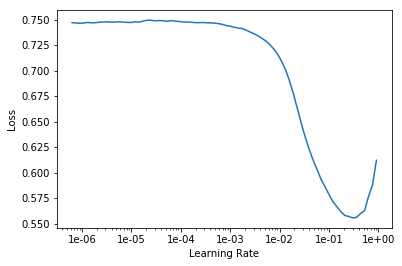

In [9]:
learn.lr_find()
learn.recorder.plot()

In [10]:
learn = cnn_learner(data, ARCH, metrics=[accuracy_thresh])
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.249217,0.228099,0.906891,04:37
1,0.232190,0.255416,0.897980,04:36
2,0.219567,0.207136,0.916365,04:34
3,0.205196,0.193688,0.921421,04:33
4,0.196889,0.189879,0.923192,04:32


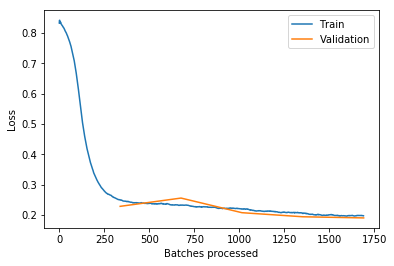

In [11]:
learn.recorder.plot_losses()

In [0]:
learn.save('res_streetstyle_crop_loss_rn34_01')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


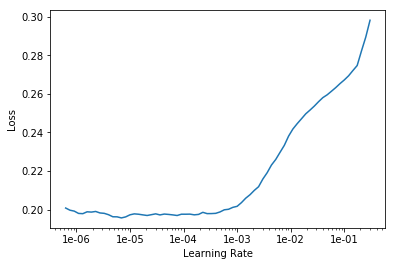

In [18]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.load('res_streetstyle_crop_loss_rn34_01')
learn.unfreeze()
learn.fit_one_cycle(5, 1e-5)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.195272,0.188510,0.924059,04:52
1,0.193533,0.185970,0.925563,04:55
2,0.191209,0.184586,0.926052,04:52
3,0.186255,0.183319,0.926494,04:52
4,0.185980,0.183501,0.926319,04:53


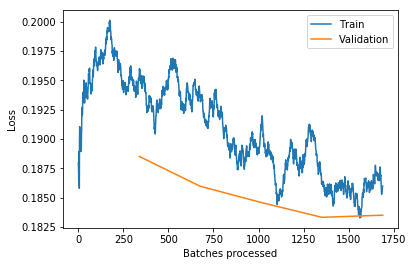

In [20]:
learn.recorder.plot_losses()

In [0]:
path = Path('/content/gdrive/My Drive/colab/model')
learn.save(path/'res_streetstyle_crop_loss_rn34_02')
#learn.save('res_streetstyle_crop_loss_rn34_02')

In [22]:
learn = cnn_learner(data, ARCH, metrics=[accuracy_thresh])
learn.load(path/'res_streetstyle_crop_loss_rn34_02')
learn.export(path/'export.pkl')
print('loaded')

loaded


Prediction

In [0]:
import sys

sys.path.append('/content/gdrive/My Drive/colab')
from plotting_fns import *

In [0]:
def get_cat_preds(probs, cats, data_classes):
    assert len(probs.shape) == 2
    idxs = get_cat_idxs(cats, data_classes)    
    return cats[probs[:, idxs].argmax(dim = 1)]
  
probs, ys = learn.get_preds(DatasetType.Valid)
val_labs = labels[labels['valid']].copy()
len(val_labs.index)

2710

Attribute classification proved to be a very challenging task for certain attributes, but much more successful in classifying other attributes. We have computed the accuracy measurements a category by category basi.  Accuracy for clothing_category is as low as 0.674.

We also see measurements greatly varying from close to high accuracy for attributes like black or white, to low accuracy for attributes like grey.

In [0]:
for cat_col in categories:
    
    cats = get_cats(val_labs, cat_col)
    val_labs['pred_'+cat_col] = get_cat_preds(probs, cats, learn.data.classes)
    
for cat_col in categories:
    na_rows = val_labs[cat_col].isna()
    acc = (val_labs.loc[~na_rows, 'pred_'+cat_col] == val_labs.loc[~na_rows, cat_col]).mean()
    print(f'Accuracy for {cat_col} is {acc}')

Accuracy for clothing_pattern is 0.8593415989739205
Accuracy for major_color is 0.7176416397973284
Accuracy for sleeve_length is 0.8092599920854768
Accuracy for neckline_shape is 0.809138505473584
Accuracy for clothing_category is 0.6743965925224799
Accuracy for multiple_layers is 0.850729086722947


Confusion matrix, without normalization


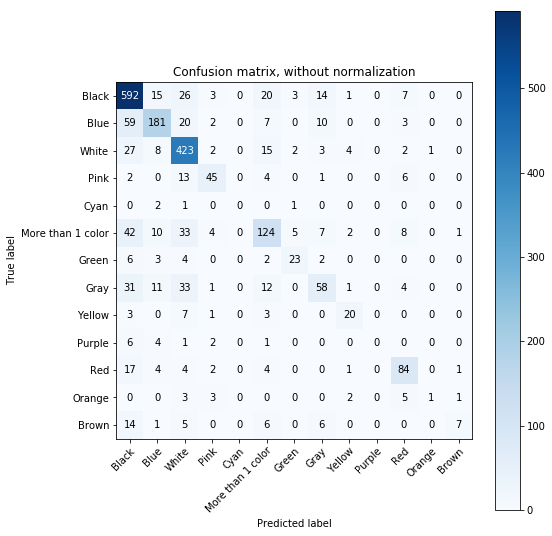

In [0]:
cat_col = 'major_color'
na_rows = val_labs[cat_col].isna()
plot_confusion_matrix(val_labs.loc[~na_rows, cat_col].apply(str), val_labs.loc[~na_rows, 'pred_'+cat_col].apply(str), figsize=(8, 8))

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(losses)
len(losses)/data.c == len(val_labs.index)

108400

Our second Model is ResNet50.

In [0]:
!ls -l data
#!rm -r streetstyle27k.tar
#!rm -r data/streetstyle27k

total 6696
drwxr-xr-x  5 root root    4096 May 15 16:15 all
drwxr-xr-x  5 root root    4096 May 15 20:07 cropped
drwxrwxr-x 18 1000 1000    4096 Aug 28  2017 streetstyle27k
-rw-r--r--  1 root root 6843031 Aug 28  2017 streetstyle27k.manifest


In [0]:
ARCH = models.resnet50
custom_loss = nn.BCEWithLogitsLoss(pos_weight=new_weights)
learn = cnn_learner(data, ARCH, metrics=[accuracy_thresh])
learn.loss_func = custom_loss

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 72688338.44it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


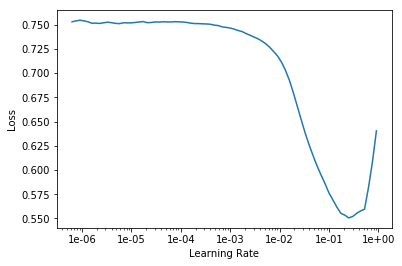

In [0]:
learn.lr_find()
learn.recorder.plot()

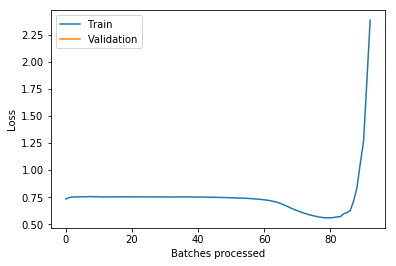

In [0]:
learn.save('res_streetstyle_crop_loss_rn50_01')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


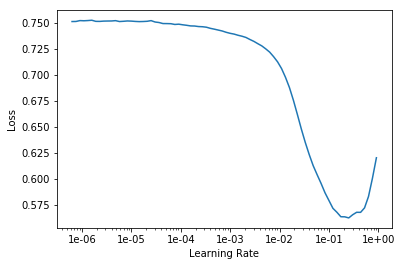

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.load('res_streetstyle_crop_loss_rn50_01')
learn.unfreeze()
learn.fit_one_cycle(5, 1e-5)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.741169,0.658241,0.513865,07:14
1,0.705100,0.624889,0.559816,07:12
2,0.673990,0.600431,0.598404,07:11
3,0.658221,0.591110,0.613035,07:10
4,0.654521,0.589838,0.615332,07:11


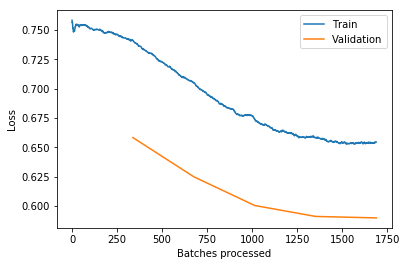

In [0]:
learn.recorder.plot_losses()

In [0]:
path = Path('/content/gdrive/My Drive/colab/model')
learn.save(path/'res_streetstyle_crop_loss_rn50_02')
#learn.save('res_streetstyle_crop_loss_rn50_02')
learn = cnn_learner(data, ARCH, metrics=[accuracy_thresh])
learn.load(path/'res_streetstyle_crop_loss_rn50_02')
print('loaded')

loaded


In [0]:
def get_cat_preds(probs, cats, data_classes):
    assert len(probs.shape) == 2
    idxs = get_cat_idxs(cats, data_classes)    
    return cats[probs[:, idxs].argmax(dim = 1)]
  
probs, ys = learn.get_preds(DatasetType.Valid)
val_labs = labels[labels['valid']].copy()

2710

In [0]:
for cat_col in categories:
    
    cats = get_cats(val_labs, cat_col)
    val_labs['pred_'+cat_col] = get_cat_preds(probs, cats, learn.data.classes)
    
for cat_col in categories:
    na_rows = val_labs[cat_col].isna()
    acc = (val_labs.loc[~na_rows, 'pred_'+cat_col] == val_labs.loc[~na_rows, cat_col]).mean()
    print(f'Accuracy for {cat_col} is {acc}')

Accuracy for clothing_pattern is 0.41470713980333473
Accuracy for major_color is 0.3321050207277752
Accuracy for sleeve_length is 0.6173328056984567
Accuracy for neckline_shape is 0.606853879105188
Accuracy for clothing_category is 0.4557501183151917
Accuracy for multiple_layers is 0.7390636991557943


Confusion matrix, without normalization


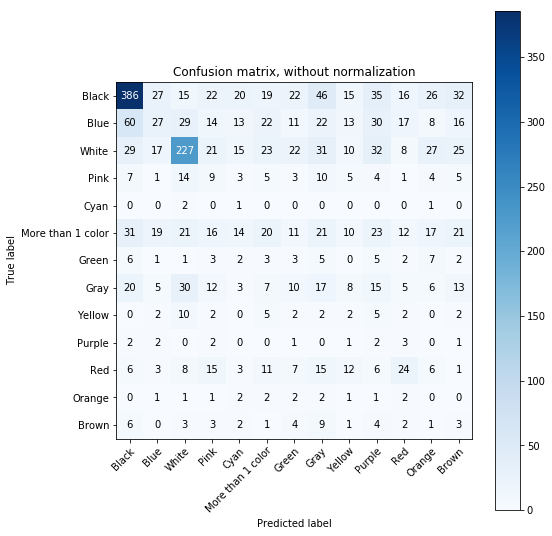

In [0]:
cat_col = 'major_color'
na_rows = val_labs[cat_col].isna()
plot_confusion_matrix(val_labs.loc[~na_rows, cat_col].apply(str), val_labs.loc[~na_rows, 'pred_'+cat_col].apply(str), figsize=(8, 8))

Third Model is ResNet18.

In [0]:
ARCH = models.resnet18
custom_loss = nn.BCEWithLogitsLoss(pos_weight=new_weights)
learn = cnn_learner(data, ARCH, metrics=[accuracy_thresh])
learn.loss_func = custom_loss

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 80849779.50it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


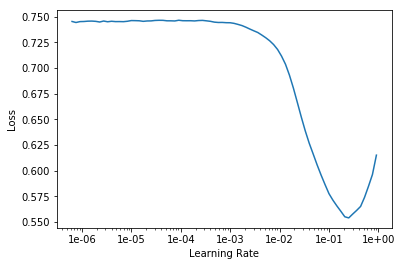

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.save('res_streetstyle_crop_loss_res18_01')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


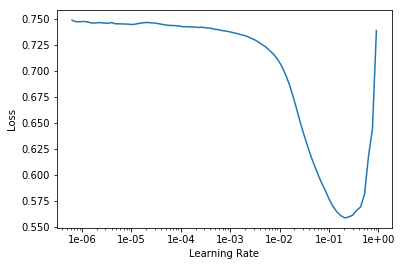

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.load('res_streetstyle_crop_loss_res18_01')
learn.unfreeze()
learn.fit_one_cycle(5, 1e-5)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.739675,0.658417,0.511790,04:23
1,0.713547,0.637342,0.536467,04:25
2,0.691819,0.618052,0.565461,04:26
3,0.680765,0.614933,0.569124,04:29
4,0.680280,0.609357,0.577371,04:29


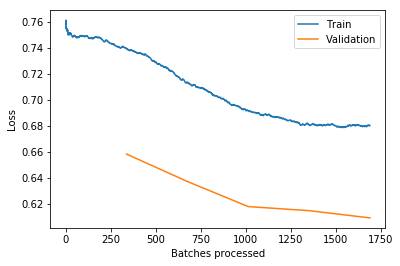

In [0]:
learn.recorder.plot_losses()

In [0]:
path = Path('/content/gdrive/My Drive/colab/model')
learn.save(path/'res_streetstyle_crop_loss_res18_02')
#learn.save('res_streetstyle_crop_loss_rn50_02')
learn = cnn_learner(data, ARCH, metrics=[accuracy_thresh])
learn.load(path/'res_streetstyle_crop_loss_res18_02')
print('loaded')

loaded


In [0]:
def get_cat_preds(probs, cats, data_classes):
    assert len(probs.shape) == 2
    idxs = get_cat_idxs(cats, data_classes)    
    return cats[probs[:, idxs].argmax(dim = 1)]
  
probs, ys = learn.get_preds(DatasetType.Valid)
val_labs = labels[labels['valid']].copy()
len(val_labs.index)

2710

Accuracy for clothing_pattern is 0.2902949978623343
Accuracy for major_color is 0.2855826807922616
Accuracy for sleeve_length is 0.5381875741986545
Accuracy for neckline_shape is 0.48357924797715374
Accuracy for clothing_category is 0.2375769048745859
Accuracy for multiple_layers is 0.6980046047582502
Confusion matrix, without normalization


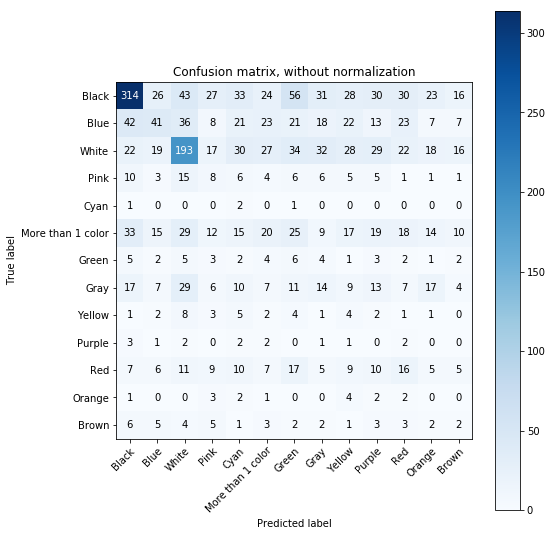

In [0]:
for cat_col in categories:
    
    cats = get_cats(val_labs, cat_col)
    val_labs['pred_'+cat_col] = get_cat_preds(probs, cats, learn.data.classes)
    
for cat_col in categories:
    na_rows = val_labs[cat_col].isna()
    acc = (val_labs.loc[~na_rows, 'pred_'+cat_col] == val_labs.loc[~na_rows, cat_col]).mean()
    print(f'Accuracy for {cat_col} is {acc}')
    
cat_col = 'major_color'
na_rows = val_labs[cat_col].isna()
plot_confusion_matrix(val_labs.loc[~na_rows, cat_col].apply(str), val_labs.loc[~na_rows, 'pred_'+cat_col].apply(str), figsize=(8, 8))

# Testing

In [0]:
learn_test = load_learner(path, test= ImageList.from_folder('data/cropped/test/'))
probs,ys = learn_test.get_preds(ds_type=DatasetType.Test)

In [47]:
def get_cat_preds(probs, cats, data_classes):
    assert len(probs.shape) == 2
    idxs = get_cat_idxs(cats, data_classes)
    res = probs[:, idxs].argmax(dim = 1)
    print(res.shape)
    return cats[probs[:, idxs].argmax(dim = 1)]

test_labs = labels[labels['test']].copy()
len(test_labs.index)

2690

In [45]:
probs.shape

torch.Size([2656, 40])

# Conclusion

We summarize our conclusions as belows:

1.   We find that the performace of ResNet50  and ResNet18 are not as good as that of ResNet34. 
2.   Attribute classification proved to be a very challenging task for certain attributes, but much more successful in classifying other attributes.
3.   Using the annotating images is better than using the origianl images.



# Next Steps

*   Continue to explore models with the updated dataset.
*   Seek better models(detection, segmentation and classification) to see how competitive it in the platform.ai
*   Discover temporal fashion patterns
*   Anotate images using Similar.ai labels.
